In [1]:
# Australian Geoscience Datacube
## Observation count

The [Australian Geoscience Datacube](https://github.com/data-cube/agdc-v2) provides an integrated gridded data analysis environment for decades of analysis ready earth observation satellite and related data from multiple satellite and other acquisition systems.

For instructions on using the Datacube on NCI, see: http://agdc-v2.readthedocs.io/en/develop/nci_usage.html

For instructions on setting up your own instance, see: http://agdc-v2.readthedocs.io/en/develop/install.html

This notebook touches briefly on some the implimented features of the Datacube module, and is only intended to deomstrat functionality rather than be a tutorial.

In [2]:
%pylab notebook
#%pylab inline
#%matplotlib inline
import datacube
import xarray as xr
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict
from matplotlib import pyplot as plt
import matplotlib.dates
import json
import pandas as pd
from IPython.display import display
import ipywidgets as widgets

Populating the interactive namespace from numpy and matplotlib


If you have set up your config correctly, or are using the module on NCI, you should be able to make `Datacube` object that can connects to the configured datacube system.

In [3]:
dc = datacube.Datacube(app='dc-example')
dc

Datacube<index=Index<db=PostgresDb<engine=Engine(postgresql://lxl554@130.56.244.227:6432/datacube)>>>

## Datacube products and measurements
The Datacube provides pandas.DataFrame representations of the available products and measurements:

In [4]:
#dc.list_products()

## Datacube Measurements
The list of measurements stored in the datacube can also be listed.

Measurements are also known as _bands_ in the imagery domain, and _data variables_ when stored in NetCDF files or when working with `xarray.Dataset` objects.

In [5]:
#dc.list_measurements()

In [6]:
#### DEFINE SPATIOTEMPORAL RANGE AND BANDS OF INTEREST
#Use this to manually define an upper left/lower right coords

#Define temporal range
start_of_epoch = '1987-01-01'
#need a variable here that defines a rolling 'latest observation'
end_of_epoch =  '2016-07-31'

#Define wavelengths/bands of interest, remove this kwarg to retrieve all bands
bands_of_interest = [#'blue',
                     #'green',
                     #'red', 
                     'nir',
                     #'swir1', 
                     #'swir2'
                     ]

#Define sensors of interest
sensor1 = 'ls8'
sensor2 = 'ls7'
sensor3 = 'ls5'

query = {
    'time': (start_of_epoch, end_of_epoch),
}

#DEFINE A LAT/LON RANGE THAT CAPTURES A NARROW AREA THAT SPANS BOTH THE SIDELAP AND NON SIDELAP AREAS
lat_max = -18.13
lat_min = -18.16
lon_max = 145.65
lon_min = 145.5
query['x'] = (lon_min, lon_max)
query['y'] = (lat_max, lat_min)
query['crs'] = 'EPSG:4326'

In [7]:
#Define the Koppen climate class here - the text is passed into figure titles at the bottom of the notebook
clim_class = 'Rainforest - persistently wet'

In [8]:
print query

{'y': (-18.13, -18.16), 'x': (145.5, 145.65), 'crs': 'EPSG:4326', 'time': ('1987-01-01', '2016-07-31')}


## Retrieve surface reflectance data


In [9]:
#Group PQ by solar day to avoid idiosyncracies of N/S overlap differences in PQ algorithm performance
pq_albers_product = dc.index.products.get_by_name(sensor1+'_pq_albers')
valid_bit = pq_albers_product.measurements['pixelquality']['flags_definition']['contiguous']['bits']

def pq_fuser(dest, src):
    valid_val = (1 << valid_bit)

    no_data_dest_mask = ~(dest & valid_val).astype(bool)
    np.copyto(dest, src, where=no_data_dest_mask)

    both_data_mask = (valid_val & dest & src).astype(bool)
    np.copyto(dest, src & dest, where=both_data_mask)

# retrieve the NBAR and PQ for the spatiotemporal range of interest


In [10]:
#Retrieve the NBAR and PQ data for sensor n
sensor1_nbar = dc.load(product= sensor1+'_nbar_albers', group_by='solar_day', measurements = bands_of_interest,  **query)
sensor1_pq = dc.load(product= sensor1+'_pq_albers', group_by='solar_day', fuse_func=pq_fuser, **query)
            

In [11]:
affine = sensor1_nbar.affine

In [12]:
#This line exists to make sure that there's a 1:1 match between NBAR and PQ
sensor1_nbar = sensor1_nbar.sel(time = sensor1_pq.time)

In [13]:
#Generate PQ masks and apply those masks to remove cloud, cloud shadow, saturated observations
s1_cloud_free = masking.make_mask(sensor1_pq, ga_good_pixel= True)
s1_good_data = s1_cloud_free.pixelquality.loc[start_of_epoch:end_of_epoch]
sensor1_nbar = sensor1_nbar.where(s1_good_data)

In [14]:
sensor2_nbar = dc.load(product= sensor2+'_nbar_albers', group_by='solar_day', measurements = bands_of_interest,  **query)
sensor2_pq = dc.load(product= sensor2+'_pq_albers', group_by='solar_day', fuse_func=pq_fuser, **query)                  

In [15]:
sensor2_nbar = sensor2_nbar.sel(time = sensor2_pq.time)

In [16]:
s2_cloud_free = masking.make_mask(sensor2_pq, ga_good_pixel= True)
s2_good_data = s2_cloud_free.pixelquality.loc[start_of_epoch:end_of_epoch]
sensor2_nbar = sensor2_nbar.where(s2_good_data)

In [17]:
sensor3_nbar = dc.load(product= sensor3+'_nbar_albers', group_by='solar_day', measurements = bands_of_interest,  **query)
sensor3_pq = dc.load(product= sensor3+'_pq_albers', group_by='solar_day', fuse_func=pq_fuser, **query)                  

In [18]:
sensor3_nbar = sensor3_nbar.sel(time = sensor3_pq.time)

In [19]:
s3_cloud_free = masking.make_mask(sensor3_pq, ga_good_pixel= True)
s3_good_data = s3_cloud_free.pixelquality.loc[start_of_epoch:end_of_epoch]
sensor3_nbar = sensor3_nbar.where(s3_good_data)

## Combining data from multiple sensors
Having masked out cloud and cloud shadow affected pixels and calculated various indices we can now combine the measurements from the different sensors to create full depth time series

In [20]:
#Concatenate and sort the different sensor xarrays into a single xarray
nbar_clean = xr.concat([sensor1_nbar, sensor2_nbar, sensor3_nbar], dim='time')
time_sorted = nbar_clean.time.argsort()
nbar_clean = nbar_clean.isel(time=time_sorted)
nbar_clean.attrs['affine'] = affine


In [21]:
#clean up per sensor xarrays to free up some memory
del sensor1_nbar
del sensor2_nbar
del sensor3_nbar

In [22]:
nbar_clean

<xarray.Dataset>
Dimensions:  (time: 1154, x: 646, y: 201)
Coordinates:
  * y        (y) float64 -2.012e+06 -2.012e+06 -2.012e+06 -2.012e+06 ...
  * x        (x) float64 1.425e+06 1.425e+06 1.425e+06 1.425e+06 1.425e+06 ...
  * time     (time) datetime64[ns] 1987-05-24 1987-07-20 1987-09-06 ...
Data variables:
    nir      (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
Attributes:
    affine: | 25.00, 0.00, 1425175.00|
| 0.00,-25.00,-2011950.00|
| 0.00, 0.00, 1.00|

## Plotting a multi-band image

In [23]:
print 'The number of time slices at this location is' 
print nbar_clean.nir.shape[0]

The number of time slices at this location is
1154


<IPython.core.display.Javascript object>


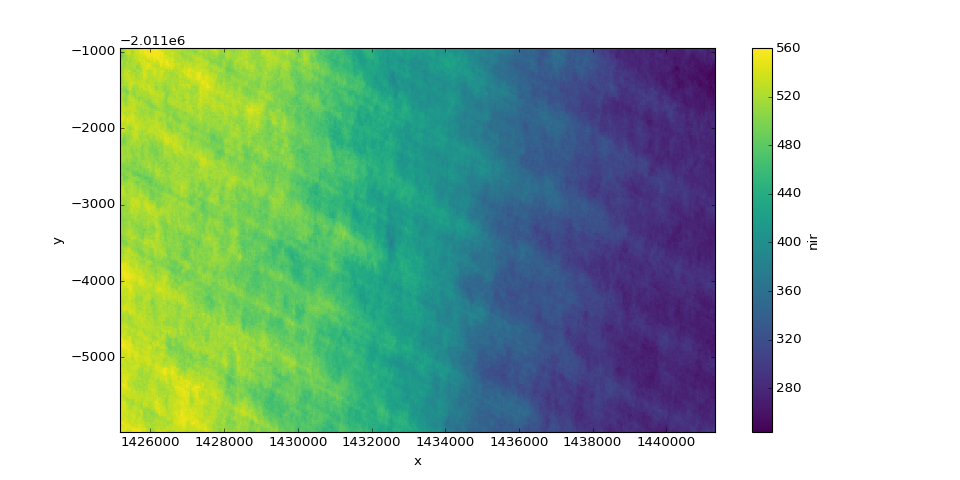

In [24]:
#Click on this image to chose the side lap pixel (high observation count)
w = widgets.HTML("Event information appears here when you click on the figure")


def callback(event):
    global x, y
    x, y = int(event.xdata + 0.5), int(event.ydata + 0.5)
    w.value = 'X: {}, Y: {}'.format(x,y)

fig = plt.figure(figsize =(12,6))
nbar_clean.nir.count('time').plot()

fig.canvas.mpl_connect('button_press_event', callback)
plt.show()
display(w)

In [25]:
x, y

(1426103, -2012057)

In [26]:

image_coords = ~nbar_clean.affine * (x, y)
xdim = int(image_coords[0])
ydim = int(image_coords[1])
xdim, ydim

(37, 4)

<IPython.core.display.Javascript object>


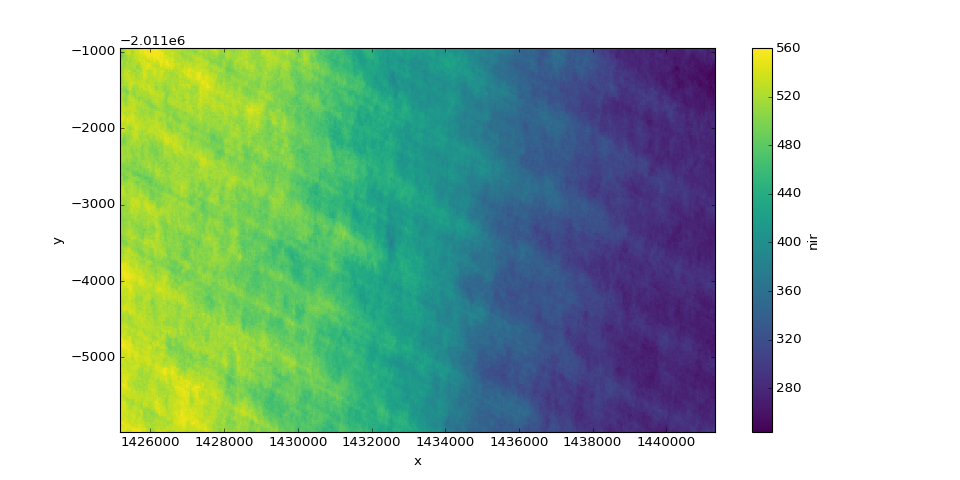

In [27]:
#Click on this image to chose the  NON side lap pixel (low observation count)
w = widgets.HTML("Event information appears here when you click on the figure")


def callback(event):
    global x2, y2
    x2, y2 = int(event.xdata + 0.5), int(event.ydata + 0.5)
    w.value = 'X: {}, Y: {}'.format(x,y)

fig = plt.figure(figsize =(12,6))
nbar_clean.nir.count('time').plot()

fig.canvas.mpl_connect('button_press_event', callback)
plt.show()
display(w)

In [30]:
image_coords2 = ~nbar_clean.affine * (x2, y2)
xdim2 = int(image_coords2[0])
ydim2 = int(image_coords2[1])
xdim2, ydim2

(626, 170)

<IPython.core.display.Javascript object>


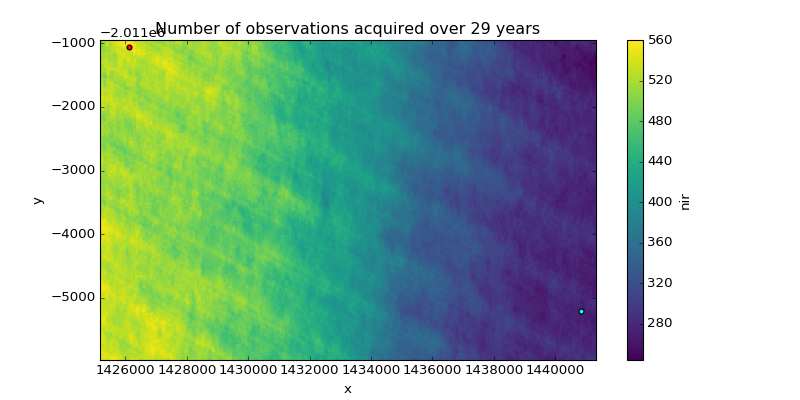

In [31]:
#This figure shows you the two locations you've selected
fig = plt.figure(figsize=(10,5))
nbar_clean.nir.count('time').plot()
plt.scatter(x=[x], y=[y], c='r')
plt.scatter(x=[x2], y=[y2], c='cyan')
plt.title('Number of observations acquired over 29 years')


In [ ]:
#midpath5, midpath78, sidelap78

In [32]:
#Drop the no data
ts = nbar_clean.nir.isel(x=[xdim],y=[ydim]).dropna('time', how = 'any')
ts2 = nbar_clean.nir.isel(x=[xdim2],y=[ydim2]).dropna('time', how = 'any')

In [33]:
midpath5 = ts2.sel(time = slice('1987-01-01', '1998-12-31' ))
midpath57 = ts2.sel(time = slice('2004-01-01', '2009-12-31' ))
midpath78 = ts2.sel(time = slice('2013-05-01', '2016-06-01' ))

In [34]:
sidelap5 = ts.sel(time = slice('1987-01-01', '1999-01-01' ))
sidelap57 = ts.sel(time = slice('2004-01-01', '2009-12-31' ))
sidelap78 = ts.sel(time = slice('2013-05-01', '2016-05-01' ))

In [35]:
#Group the data by month to see total number of observations per month over the full depth of archive
midpath5_month = midpath5.groupby('time.month')
midpath57_month = midpath57.groupby('time.month')
midpath78_month = midpath78.groupby('time.month')
sidelap57_month = sidelap57.groupby('time.month')
sidelap78_month = sidelap78.groupby('time.month')

In [36]:
sidelap78_month.count()

<xarray.DataArray 'nir' (month: 12)>
array([ 6,  2,  5,  3,  8,  5, 10, 10,  9, 16, 12,  9])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [37]:
midpath5_month_norm = midpath5_month.count()/12.0 #where 12 years is the time frame from 1987 - 1998
midpath57_month_norm = midpath57_month.count()/6.0 #where 6 is the number of years from 2004 - 2009 (chosen because of LS5 issues)
midpath78_month_norm = midpath78_month.count()/3.0 #where 3 is the number of years from May 2013 to May 2016
sidelap57_month_norm = sidelap57_month.count()/6.0
sidelap78_month_norm = sidelap78_month.count()/3.0

<IPython.core.display.Javascript object>


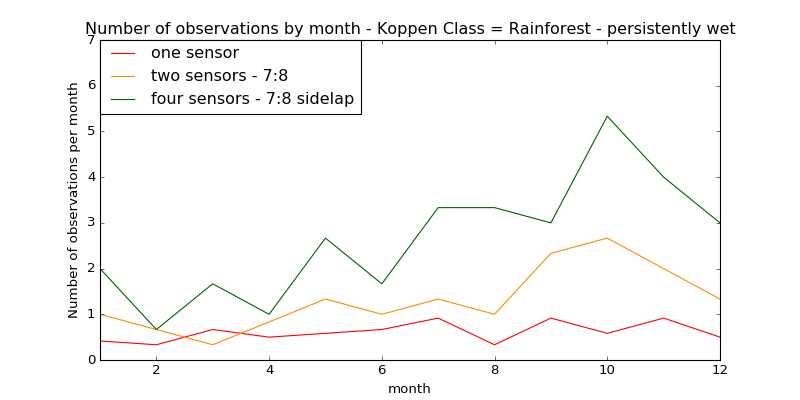

<function matplotlib.pyplot.show>

In [38]:
fig = plt.figure(figsize=(10,5))
midpath5_month_norm.plot(label = 'one sensor', color = 'r')
#midpath57_month_norm.plot(label = 'two sensors - 5:7', color = 'orange')
midpath78_month_norm.plot(label = 'two sensors - 7:8', color = 'darkorange')
#sidelap57_month_norm.plot(label = 'four sensors - 5:7 sidelap', color = 'green')
sidelap78_month_norm.plot(label = 'four sensors - 7:8 sidelap', color = 'darkgreen')

#ts4sensor57_month.count().plot(label = 'four sensors57')

plt.title('Number of observations by month - Koppen Class = ' +clim_class)
plt.ylabel('Number of observations per month')
plt.legend(bbox_to_anchor = (0, 1), loc = 2, borderaxespad = 0.)
plt.axis([1 , 12 ,0, 7])
plt.show

In [39]:
#group by year to see total number of observations per year
tsg_year = ts.groupby('time.year')
tsg2_year = ts2.groupby('time.year')

<IPython.core.display.Javascript object>


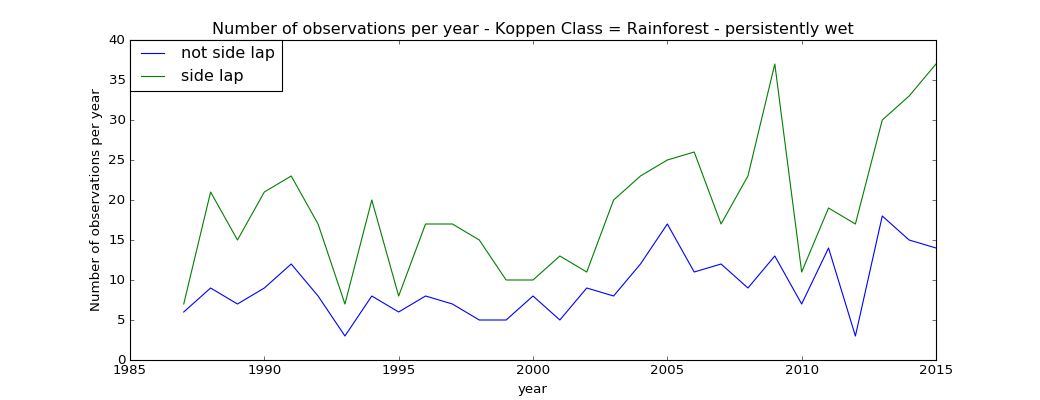

In [40]:
fig = plt.figure(figsize=(13,5))
tsg2_year.count().plot(label = 'not side lap')
tsg_year.count().plot(label = 'side lap')
plt.ylabel('Number of observations per year')
plt.title('Number of observations per year - Koppen Class = ' +clim_class)
#plt.axis(['1987' , '2015' ,0, 40])

plt.legend(bbox_to_anchor = (0, 1), loc = 2, borderaxespad = 0.)



<IPython.core.display.Javascript object>


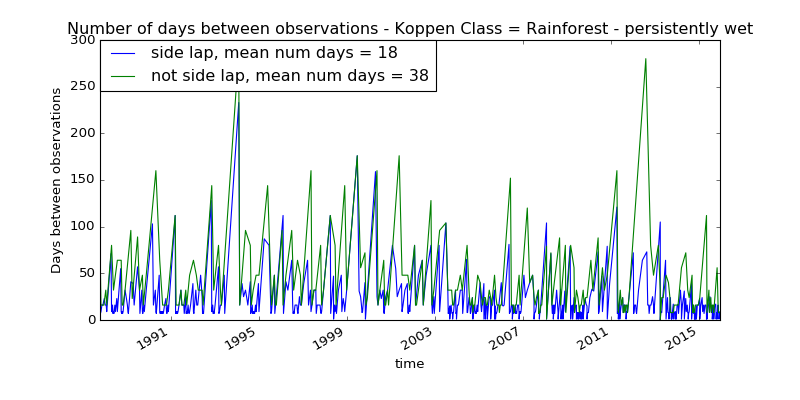

The average number of days between observations in the sidelap is
18
The average number of days between observations outside the sidelap is
38


In [41]:
fig = plt.figure(figsize=(10,5))
#Calculate a timedelta to quantify the gaps between observations
x = ts.time - ts.time.shift(time=1)
x2 = ts2.time - ts2.time.shift(time=1)
days = x.astype('timedelta64[D]')
days2 = x2.astype('timedelta64[D]')

delta = days/np.timedelta64(1, 'D')
delta2 = days2/np.timedelta64(1, 'D')

print 'The average number of days between observations in the sidelap is' 
print int(delta.mean().values)
print 'The average number of days between observations outside the sidelap is' 
print int (delta2.mean().values)

delta.plot(label = 'side lap, mean num days = '+str(int(delta.mean().values)))
delta2.plot(label = 'not side lap, mean num days = '+str(int(delta2.mean().values)))
plt.ylabel("Days between observations")
plt.legend(bbox_to_anchor = (0, 1), loc = 2, borderaxespad = 0.)
plt.title('Number of days between observations - Koppen Class = ' +clim_class)


    #time_int_ = time_int.astype(datetime64[D])

In [42]:
delta2

<xarray.DataArray 'time' (time: 268)>
array([  nan,   80.,   16.,   16.,   16.,   16.,   32.,   16.,   80.,
         32.,   64.,   64.,   16.,   16.,   32.,   96.,   23.,   89.,
         32.,   48.,   16.,   48.,  160.,   64.,   32.,   16.,   16.,
         16.,   16.,   16.,   32.,  112.,   16.,   16.,   16.,   16.,
         32.,   16.,   16.,   16.,   32.,   16.,   48.,   64.,   48.,
         32.,   32.,   32.,   16.,  144.,   32.,   80.,   32.,   16.,
        288.,   16.,   96.,   80.,   16.,   32.,   48.,   48.,  144.,
         48.,   16.,   48.,   16.,   16.,   96.,   16.,   48.,   96.,
         32.,   64.,   48.,   16.,  160.,   16.,   32.,   32.,   80.,
         16.,   32.,  112.,   80.,   16.,  144.,   32.,  176.,   56.,
         72.,   16.,   24.,  160.,   16.,   32.,   64.,   16.,   16.,
         32.,   16.,  176.,   48.,   48.,   48.,   32.,   80.,   16.,
         16.,   32.,   64.,   16.,  128.,   16.,   32.,   96.,  104.,
         32.,   32.,   32.,   16.,   16.,   32.,   3

<IPython.core.display.Javascript object>


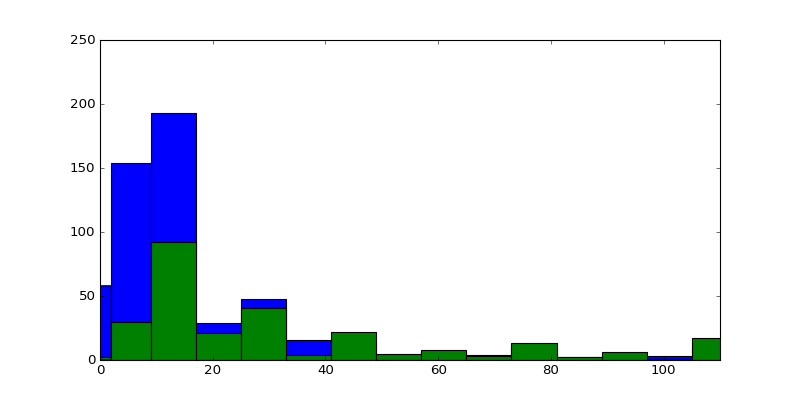

[0, 110, 0, 250]

In [43]:
fig = plt.figure(figsize=(10,5))
plt.hist(delta.dropna('time', how = 'any'), bins = (0, 2, 9, 17, 25, 33, 41, 49, 57, 65, 73, 81, 89, 97, 105, 365 ))#, normed = True)
plt.hist(delta2.dropna('time', how = 'any'), bins = (0, 2, 9, 17, 25, 33, 41, 49, 57, 65, 73, 81, 89, 97, 105, 365 ))#, normed = True)

#plt.hist(delta2.dropna('time', how = 'any'), 365)
plt.axis([0, 110 ,0, 250])

<IPython.core.display.Javascript object>


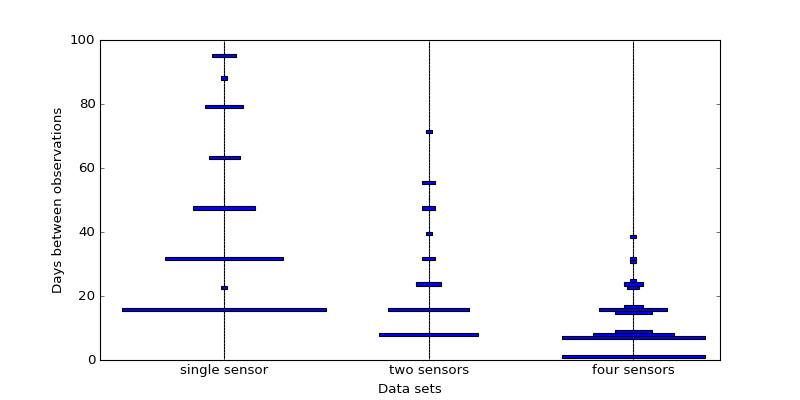

In [60]:
fig = plt.figure(figsize=(10,5))
"""x = ts.time - ts.time.shift(time=1)
x2 = ts2.time - ts2.time.shift(time=1)
days = x.astype('timedelta64[D]')
days2 = x2.astype('timedelta64[D]')"""
#midpath5, midpath78, sidelap78
mp5 = midpath5.time - midpath5.time.shift(time=1)
mp78 = midpath78.time - midpath78.time.shift(time=1)
slap78 = sidelap78.time - sidelap78.time.shift(time=1)
mp5days = mp5.astype('timedelta64[D]')
mp78days = mp78.astype('timedelta64[D]')
slap78days = slap78.astype('timedelta64[D]')

mp5delta = mp5days/np.timedelta64(1, 'D')
mp78delta = mp78days/np.timedelta64(1, 'D')
slap78delta = slap78days/np.timedelta64(1, 'D')

#sidelap = delta.dropna('time', how = 'any')

mp5delta = mp5delta.dropna('time', how = 'any')
mp78delta = mp78delta.dropna('time', how = 'any')
slap78delta = slap78delta.dropna('time', how = 'any')
number_of_bins = 101
# An example of three data sets to compare
labels = ["single sensor", "two sensors", "four sensors"]
data_sets = [mp5delta, mp78delta, slap78delta]

# Computed quantities to aid plotting
hist_range = (0, 100)
"""binned_data_sets = [np.histogram(d, range=hist_range, bins = (0, 2, 9, 17, 25, 33, 41, 49, 57, 65, 73, 81, 89, 97, 105, 365 ))[0]
                    for d in data_sets]
binned_maximums = np.max(binned_data_sets, axis=1)
x_locations = np.arange(0, sum(binned_maximums), np.max(binned_maximums))"""

binned_data_sets = [np.histogram(d, range=hist_range, bins=number_of_bins)[0]
                    for d in data_sets]
binned_maximums = np.max(binned_data_sets, axis=1)
x_locations = np.arange(0, sum(binned_maximums), np.max(binned_maximums))

# The bin_edges are the same for all of the histograms
bin_edges = np.linspace(hist_range[0], hist_range[1], number_of_bins + 1)
centers = .5 * (bin_edges + np.roll(bin_edges, 1))[:-1]
heights = np.diff(bin_edges)

# Cycle through and plot each histogram
ax = plt.subplot(111)
for x_loc, binned_data in zip(x_locations, binned_data_sets):
    lefts = x_loc - .5 * binned_data
    ax.barh(centers, binned_data, height=heights, left=lefts)
    


ax.set_xticks(x_locations)
ax.set_xticklabels(labels)

ax.set_ylabel("Days between observations")
ax.set_xlabel("Data sets")
plt.show()

In [58]:
x_locations

array([ 0, 33, 66])

In [47]:
slap78delta 

<xarray.DataArray 'time' (time: 94)>
array([  7.,   1.,  24.,   8.,   8.,   7.,   1.,  24.,   8.,   7.,   1.,
         7.,   1.,   7.,  17.,   7.,   1.,   8.,   7.,   9.,   7.,   1.,
         7.,   1.,  15.,  17.,   7.,  32.,  16.,   1.,  16.,  31.,   1.,
        23.,   9.,  16.,   8.,   7.,   1.,   7.,   9.,  39.,   1.,   8.,
         8.,  16.,   7.,   8.,   1.,   7.,   1.,   7.,   1.,  15.,   1.,
        16.,  16.,  23.,   1.,  15.,  24.,   9.,  16.,   7.,  16.,  16.,
         8.,   1.,   7.,   1.,   8.,  15.,  25.,  16.,   8.,  15.,   1.,
         7.,   9.,   7.,   1.,  15.,  17.,   7.,   1.,   8.,   7.,   1.,
        16.,   8.,   7.,   1.,   7.,   9.])
Coordinates:
  * time     (time) datetime64[ns] 2013-07-02 2013-07-03 2013-07-27 ...